In [1]:
import gym
import numpy as np
import random
from collections import deque
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Create directories to save model output
output_dir = 'model_output/cartpole/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open("scores.txt", "w") as f:
    f.write("")

In [3]:
env = gym.make('CartPole-v1',render_mode="rgb_array") # Create the environment for the cartpole

In [4]:
# Hyperparameters
learning_rate = 0.0005
batch_size = 32
n_episodes = 500
deque_memory_size = 2000
output_dir = 'model_output/cartpole/'

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.999  # discount factor

# Environment variables
# 4 = cart position, cart velocity, pole angle, pole velocity at the tip
state_size = env.observation_space.shape[0]
action_size = env.action_space.n  # two actions: left and right

In [5]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class DQNAgent:
    def __init__(self):
        self.model = DQN()
        self.target_model = DQN()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=deque_memory_size)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma

    def act(self, state, explore=True):
        if explore and np.random.rand() <= self.epsilon:
            return random.randrange(action_size)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.numpy())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.target_model(next_state)).item())
            target_f = self.model(state)
            target_f = target_f.clone()
            target_f[0][action] = target
            self.optimizer.zero_grad()
            output = self.model(state)
            loss = self.loss_fn(output, target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save(self, name):
        torch.save(self.model.state_dict(), name)
        
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        self.target_model.load_state_dict(torch.load(name))

In [8]:
# Train the agent
agent = DQNAgent()
done = False
scores = []  # store the scores

for e in range(n_episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = np.array(state[0]).reshape([1, state_size])
        # print(state)
    done = False
    tReward = 0
    while not done:
        # env.render()
        action = agent.act(state)
        step_action = env.step(action)

        next_state = np.array(step_action[0]).reshape([1, state_size])
        reward = step_action[1]
        done = step_action[2]

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        tReward += reward
        agent.replay(batch_size)
        if(tReward > 1000): # if the agent has reached very high score, break the loop
            break

    agent.update_target_model()
    scores.append(tReward)
    print(f"Episode: {e}/{n_episodes}, Score: {tReward}, Epsilon: {agent.epsilon:.2}")
    # appending the score in a file
    with open('scores.txt', 'a') as file:
        file.write(
            f"Episode: {e}/{n_episodes}, Score: {tReward}, Epsilon: {agent.epsilon:.2}\n")
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    if e % 50 == 0:
        agent.save(output_dir + 'model.weights.pth')

Episode: 0/500, Score: 23.0, Epsilon: 1.0
Episode: 1/500, Score: 17.0, Epsilon: 0.99
Episode: 2/500, Score: 20.0, Epsilon: 0.99
Episode: 3/500, Score: 13.0, Epsilon: 0.99
Episode: 4/500, Score: 18.0, Epsilon: 0.98
Episode: 5/500, Score: 33.0, Epsilon: 0.98
Episode: 6/500, Score: 18.0, Epsilon: 0.97
Episode: 7/500, Score: 33.0, Epsilon: 0.97
Episode: 8/500, Score: 41.0, Epsilon: 0.96
Episode: 9/500, Score: 24.0, Epsilon: 0.96
Episode: 10/500, Score: 45.0, Epsilon: 0.95
Episode: 11/500, Score: 37.0, Epsilon: 0.95
Episode: 12/500, Score: 10.0, Epsilon: 0.94
Episode: 13/500, Score: 20.0, Epsilon: 0.94
Episode: 14/500, Score: 28.0, Epsilon: 0.93
Episode: 15/500, Score: 12.0, Epsilon: 0.93
Episode: 16/500, Score: 13.0, Epsilon: 0.92
Episode: 17/500, Score: 22.0, Epsilon: 0.92
Episode: 18/500, Score: 13.0, Epsilon: 0.91
Episode: 19/500, Score: 23.0, Epsilon: 0.91
Episode: 20/500, Score: 14.0, Epsilon: 0.9
Episode: 21/500, Score: 14.0, Epsilon: 0.9
Episode: 22/500, Score: 34.0, Epsilon: 0.9
Ep

[23.0, 17.0, 20.0, 13.0, 18.0, 33.0, 18.0, 33.0, 41.0, 24.0, 45.0, 37.0, 10.0, 20.0, 28.0, 12.0, 13.0, 22.0, 13.0, 23.0, 14.0, 14.0, 34.0, 15.0, 17.0, 39.0, 39.0, 21.0, 15.0, 14.0, 35.0, 13.0, 24.0, 33.0, 23.0, 22.0, 30.0, 75.0, 27.0, 65.0, 32.0, 13.0, 75.0, 19.0, 24.0, 14.0, 34.0, 57.0, 21.0, 49.0, 26.0, 13.0, 67.0, 28.0, 65.0, 12.0, 15.0, 52.0, 17.0, 72.0, 14.0, 17.0, 24.0, 41.0, 25.0, 17.0, 20.0, 47.0, 36.0, 31.0, 99.0, 84.0, 25.0, 82.0, 67.0, 21.0, 68.0, 49.0, 127.0, 84.0, 99.0, 15.0, 276.0, 28.0, 160.0, 32.0, 29.0, 36.0, 54.0, 47.0, 51.0, 30.0, 219.0, 157.0, 10.0, 111.0, 12.0, 71.0, 39.0, 38.0, 91.0, 126.0, 120.0, 38.0, 196.0, 94.0, 38.0, 20.0, 172.0, 169.0, 57.0, 50.0, 39.0, 205.0, 107.0, 36.0, 257.0, 66.0, 24.0, 180.0, 213.0, 364.0, 75.0, 276.0, 211.0, 211.0, 12.0, 34.0, 36.0, 223.0, 105.0, 157.0, 82.0, 188.0, 21.0, 24.0, 104.0, 75.0, 88.0, 147.0, 198.0, 14.0, 98.0, 13.0, 54.0, 27.0, 58.0, 161.0, 311.0, 88.0, 99.0, 80.0, 20.0, 69.0, 42.0, 25.0, 218.0, 111.0, 291.0, 178.0, 200.0,

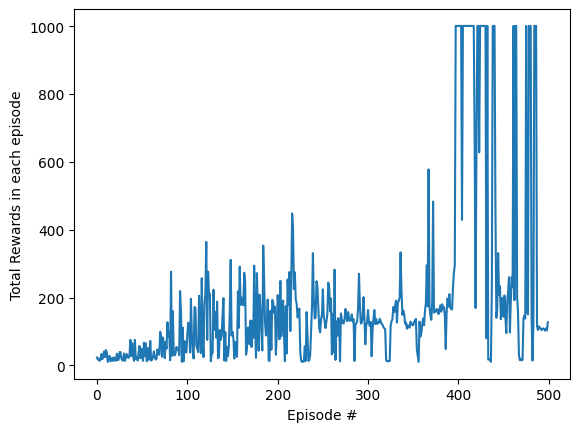

<Figure size 640x480 with 0 Axes>

In [9]:
# Print scores
print(scores)
# Plotting the total rewards
plt.plot(scores)
plt.ylabel('Total Rewards in each episode')
plt.xlabel('Episode #')
plt.show()
plt.savefig('cartpole_rewards.png')

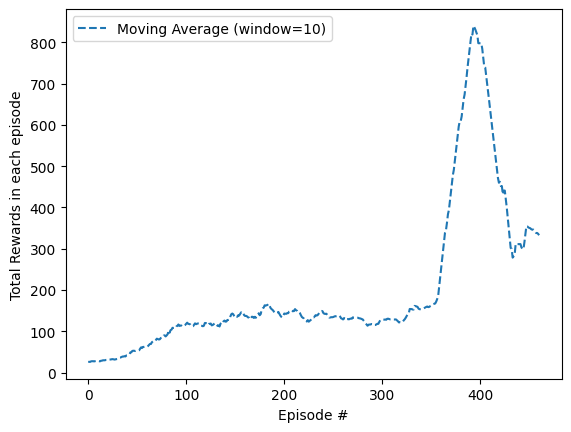

In [15]:
# Calculate moving average for the best-fit line
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plotting the total rewards
plt.plot(moving_average(scores, 40), label='Moving Average (window=10)', linestyle='--')
plt.ylabel('Total Rewards in each episode')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [54]:
def evaluate_agent(agent, env, n_episodes=10):
    total_rewards = []
    for e in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = np.array(state[0]).reshape([1, state_size])
        done = False
        tReward = 0
        while not done:
            action = agent.act(state)
            step_action = env.step(action)

            next_state = np.array(step_action[0]).reshape([1, state_size])
            reward = step_action[1]
            done = step_action[2]

            state = next_state
            tReward += reward
        
        total_rewards.append(tReward)
        print(f"Episode: {e+1}/{n_episodes}, Score: {tReward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {n_episodes} episodes: {avg_reward}")
    return total_rewards, avg_reward

# Load and evaluate the model
agent = DQNAgent()
agent.load(output_dir + 'model-200.weights.pth')

# Evaluate the agent
evaluate_agent(agent, env)

Episode: 1/10, Score: 11.0
Episode: 2/10, Score: 17.0
Episode: 3/10, Score: 12.0
Episode: 4/10, Score: 26.0
Episode: 5/10, Score: 40.0
Episode: 6/10, Score: 29.0
Episode: 7/10, Score: 42.0
Episode: 8/10, Score: 23.0
Episode: 9/10, Score: 13.0
Episode: 10/10, Score: 11.0
Average Reward over 10 episodes: 22.4


([11.0, 17.0, 12.0, 26.0, 40.0, 29.0, 42.0, 23.0, 13.0, 11.0], 22.4)